## 1. Introduction

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medical-insurance-cost-prediction/medical-charges.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
filepath = '/kaggle/input/medical-insurance-cost-prediction/medical-charges.csv'
charge = pd.read_csv(filepath)
charge.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 2. Exploratory Data Analysis

In [4]:
charge.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [5]:
charge.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Children, smoker, region?

In [6]:
print('Dataset Shape: ', charge.shape)
print('Duplicate count: ',charge.duplicated().sum())
print('Null count by feature:',charge.isna().sum())
print('Null count by feature:',charge.isna().sum().sum())

Dataset Shape:  (1338, 7)
Duplicate count:  1
Null count by feature: age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
Null count by feature: 0


In [7]:
#Drop Duplicates
charge.drop_duplicates(inplace=True)
print(charge.shape)

(1337, 7)


In [8]:
#Feature Distribution
features = ['children','smoker','region']

for feat in features:
    print(charge[feat].value_counts(), '\n')
    print('Normalized')
    print(charge[feat].value_counts(normalize=True), ' \n')


children
0    573
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64 

Normalized
children
0    0.428571
1    0.242334
2    0.179506
3    0.117427
4    0.018699
5    0.013463
Name: proportion, dtype: float64  

smoker
no     1063
yes     274
Name: count, dtype: int64 

Normalized
smoker
no     0.795064
yes    0.204936
Name: proportion, dtype: float64  

region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64 

Normalized
region
southeast    0.272251
southwest    0.243082
northwest    0.242334
northeast    0.242334
Name: proportion, dtype: float64  



region is is fairly balanced, smoker is heavy on 'No', children distribution declines for each additional child

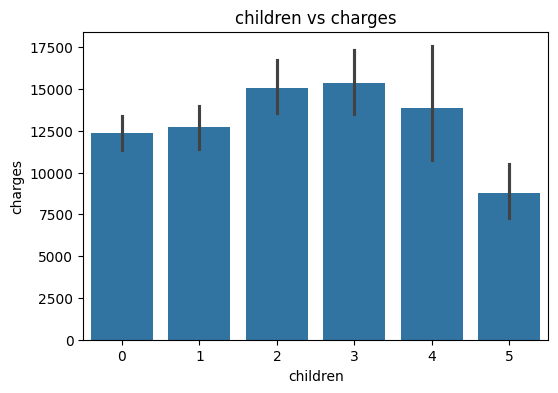

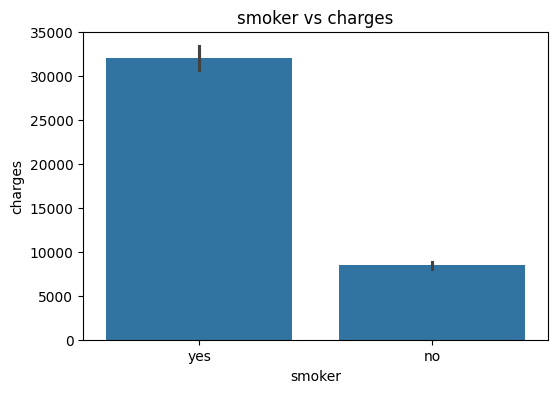

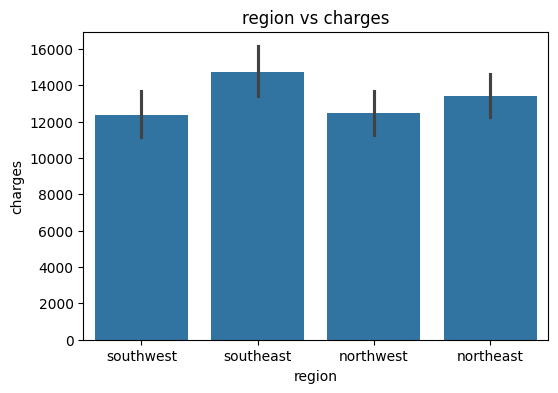

In [9]:
for f in features:
    plt.figure(figsize=(6,4))
    sns.barplot(x=f, y='charges', data=charge)
    plt.title(f'{f} vs charges')
    plt.show()

Smoking shows a strong association with insurnace charges, smokers paying significantly more on average. The number of children shows a weak and non-linear relationship with charges, while regional differences are relatively small, though the Southeast displays slightly higher average costs.


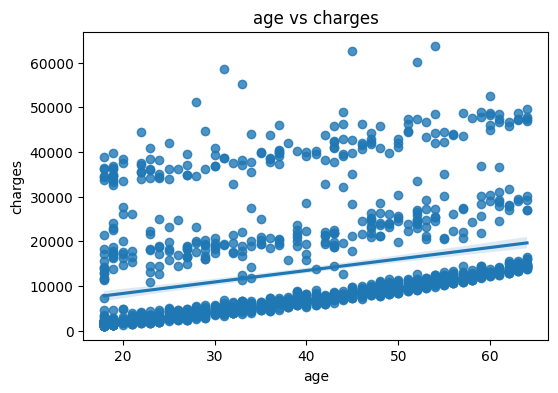

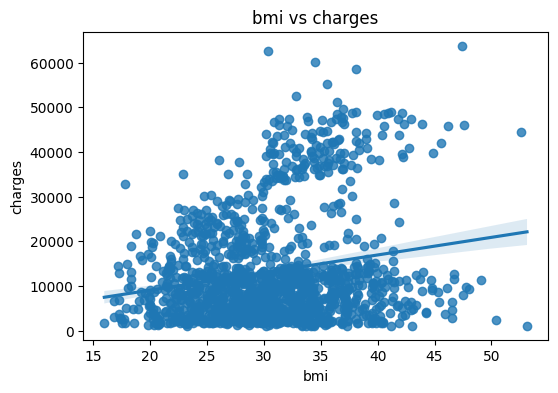

In [10]:
for s in ['age','bmi']:
    plt.figure(figsize=(6,4))
    sns.regplot(x=s, y='charges', data=charge)
    plt.title(f'{s} vs charges')
    plt.show()

Age and BMI show moderate positive associations with insurance charges; however, the relationship is strongly non-uniform, suggesting interaction effects with other variables, most notably smoking status.

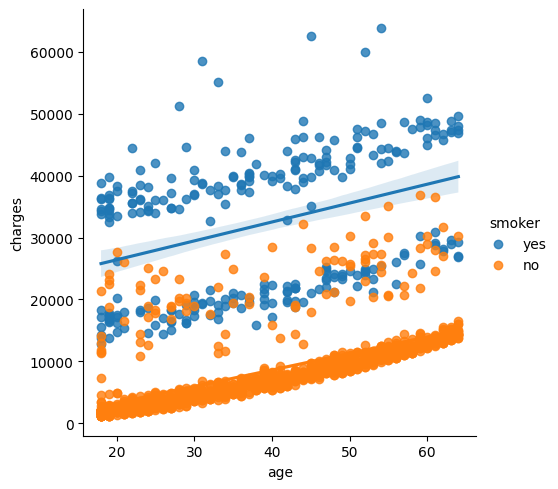

In [11]:
sns.lmplot(data=charge, x='age' ,y='charges', hue='smoker')

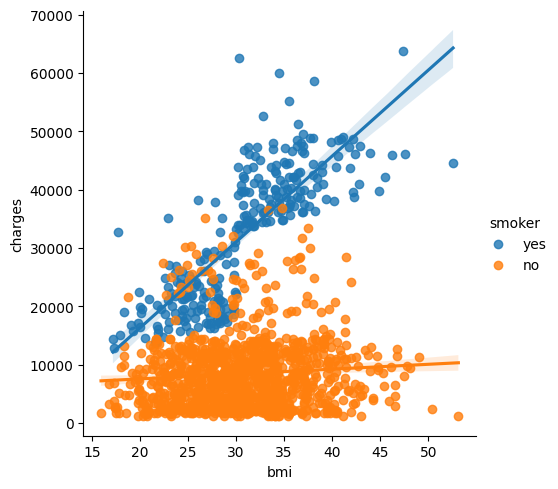

In [12]:
sns.lmplot(data=charge, x='bmi' ,y='charges', hue='smoker')

Insurance charges increase gradually with age across both smoking groups; however, smokers consistently incur substantially higher costs at all ages. BMI exhibits a weak and near-linear relationship with charges among non-smokers, while among smokers the relationship is markedly non-linear, with charges increasing sharply as BMI rises. This pattern suggests a strong interaction effect between BMI and smoking status.

## 3. Feature Engineering

Creating dummy encoded columns for region and dropping the first. Dummy Enconding not one hot

In [13]:
#Encode Variables dummy encoding
one_hot = pd.get_dummies(charge['region'], drop_first=True, dtype=int)
charge = pd.concat([charge, one_hot], axis = 1)
charge.drop('region', axis=1, inplace=True)
charge.head()


,age,sex,bmi,children,smoker,charges,northwest,southeast,southwest
0,19,female,27.900,0,yes,16884.92400,0,0,1
1,18,male,33.770,1,no,1725.55230,0,1,0
2,28,male,33.000,3,no,4449.46200,0,1,0
3,33,male,22.705,0,no,21984.47061,1,0,0
4,32,male,28.880,0,no,3866.85520,1,0,0


Mapping 0 to female and 1 to male and dropping the 'sex' column

In [14]:
charge['sex_encoded'] = charge['sex'].map({"female":0, "male": 1})
charge.drop('sex', axis=1, inplace=True)
charge.head()

,age,bmi,children,smoker,charges,northwest,southeast,southwest,sex_encoded
0,19,27.900,0,yes,16884.92400,0,0,1,0
1,18,33.770,1,no,1725.55230,0,1,0,1
2,28,33.000,3,no,4449.46200,0,1,0,1
3,33,22.705,0,no,21984.47061,1,0,0,1
4,32,28.880,0,no,3866.85520,1,0,0,1


Similar to above, mapping 0 to no and 1 to yes plus dropping the smoker column

In [15]:
charge['smoker_encoded'] = charge['smoker'].map({"no":0, "yes": 1})
charge.drop('smoker', axis=1, inplace=True)
charge.head()

,age,bmi,children,charges,northwest,southeast,southwest,sex_encoded,smoker_encoded
0,19,27.900,0,16884.92400,0,0,1,0,1
1,18,33.770,1,1725.55230,0,1,0,1,0
2,28,33.000,3,4449.46200,0,1,0,1,0
3,33,22.705,0,21984.47061,1,0,0,1,0
4,32,28.880,0,3866.85520,1,0,0,1,0


Engineering 2 new features based off graphs in EDA showing that BMI + smoker explodes costs and age + smoker has higher threshold for costs

In [16]:
charge["bmi_smoker"] = charge["bmi"] * charge["smoker_encoded"]
charge["age_smoker"] = charge["age"] * charge["smoker_encoded"]

<Axes: >

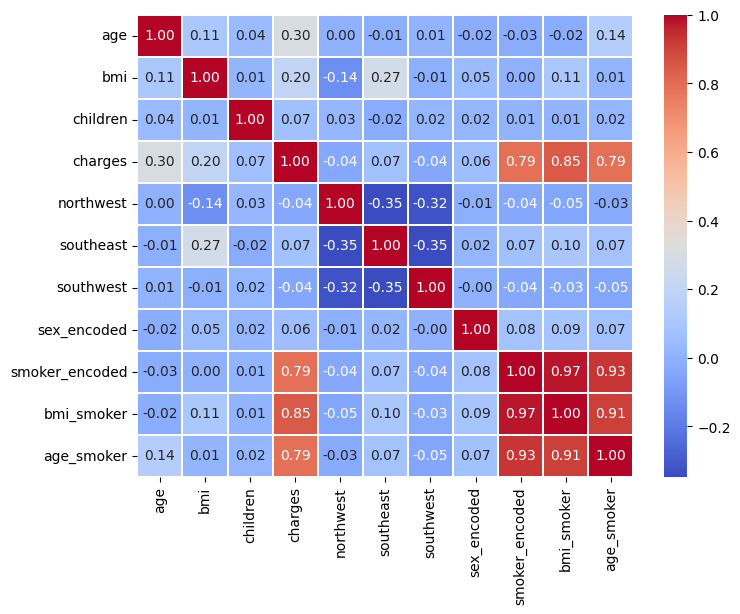

In [17]:
corr = charge.corr()
plt.figure(figsize=(8,6))

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".02f", linewidths=0.1)

## 4. Modeling

In [18]:
#Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [19]:
X = charge.drop(columns='charges')
y = charge['charges']

In [20]:
#Scale only numeric columns
num_cols = ["age","bmi",'children','bmi_smoker','age_smoker']
cat_cols = ['northwest','southeast','southwest','sex_encoded','smoker_encoded']

In [21]:
# Train-test split FIRST
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

# Scale numeric cols only (fit on train, transform both)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [22]:
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

In [23]:
# Baseline: Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)

In [24]:
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

print(f"Linear Regression -> RMSE: {lr_rmse:,.2f} | R²: {lr_r2:.4f}")

Linear Regression -> RMSE: 4,611.61 | R²: 0.8770


In [25]:
# Ridge
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)

ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
ridge_r2 = r2_score(y_test, ridge_pred)

print(f"Ridge (alpha=1.0) -> RMSE: {ridge_rmse:,.2f} | R²: {ridge_r2:.4f}")

Ridge (alpha=1.0) -> RMSE: 4,592.58 | R²: 0.8780


In [26]:

alphas = np.logspace(-3, 3, 25)

ridge_gs = GridSearchCV(
    Ridge(),
    param_grid={"alpha": alphas},
    scoring="neg_root_mean_squared_error",
    cv=5
)
ridge_gs.fit(X_train_scaled, y_train)

best_ridge = ridge_gs.best_estimator_
print("Best alpha:", ridge_gs.best_params_["alpha"])

best_pred = best_ridge.predict(X_test_scaled)
best_rmse = np.sqrt(mean_squared_error(y_test, best_pred))
best_r2 = r2_score(y_test, best_pred)

print(f"Tuned Ridge -> RMSE: {best_rmse:,.2f} | R²: {best_r2:.4f}")

Best alpha: 0.1
Tuned Ridge -> RMSE: 4,607.73 | R²: 0.8772


Ridge regression achieved strong predictive performance (R² ≈ 0.88, RMSE ≈ $4.6k). Hyperparameter tuning produced minimal improvement over the default regularization strength, suggesting that the engineered feature set captures the underlying signal effectively while benefiting primarily from coefficient stabilization rather than aggressive regularization.

In [29]:
train_pred = ridge.predict(X_train_scaled)
test_pred = ridge.predict(X_test_scaled)

train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print(f"Train RMSE: {train_rmse:,.2f}")
print(f"Test RMSE:  {test_rmse:,.2f}")

Train RMSE: 4,920.08
Test RMSE:  4,592.58


In [28]:
from sklearn.model_selection import cross_val_score

cv_rmse = -cross_val_score(
    ridge,
    X_train_scaled,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=5
)

cv_rmse.mean(), cv_rmse.std()

(np.float64(4949.724476828437), np.float64(420.59894026458375))

In [30]:
from sklearn.ensemble import RandomForestRegressor


# Random Forest
rf = RandomForestRegressor(
    n_estimators=600,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=2
)
rf.fit(X_train, y_train)

rf_pred_train = rf.predict(X_train)
rf_pred_test = rf.predict(X_test)

rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_pred_train))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_pred_test))
rf_test_r2 = r2_score(y_test, rf_pred_test)

print(f"Random Forest -> Train RMSE: {rf_train_rmse:,.2f}")
print(f"Random Forest -> Test  RMSE: {rf_test_rmse:,.2f} | R²: {rf_test_r2:.4f}")

Random Forest -> Train RMSE: 2,861.45
Random Forest -> Test  RMSE: 4,589.91 | R²: 0.8782


While Random Forest achieves comparable test performance, it exhibits substantial overfitting as evidenced by a large train–test error gap. Ridge regression provides equivalent predictive accuracy with improved generalization stability and interpretability.

In [31]:
from sklearn.ensemble import HistGradientBoostingRegressor


hgb = HistGradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=6,
    max_iter=600,
    random_state=42
)
hgb.fit(X_train, y_train)

hgb_pred_train = hgb.predict(X_train)
hgb_pred_test = hgb.predict(X_test)

hgb_train_rmse = np.sqrt(mean_squared_error(y_train, hgb_pred_train))
hgb_test_rmse = np.sqrt(mean_squared_error(y_test, hgb_pred_test))
hgb_test_r2 = r2_score(y_test, hgb_pred_test)

print(f"HistGB -> Train RMSE: {hgb_train_rmse:,.2f}")
print(f"HistGB -> Test  RMSE: {hgb_test_rmse:,.2f} | R²: {hgb_test_r2:.4f}")

HistGB -> Train RMSE: 2,924.83
HistGB -> Test  RMSE: 4,726.42 | R²: 0.8708


Tree-based models achieved similar or slightly worse generalization performance while exhibiting substantial overfitting. A regularized linear model with interaction features provided the best balance of predictive accuracy, stability, and interpretability.